In [1]:
import transformers
import pandas
import numpy
import torch
import json

/home/jsegvic/.conda/envs/env_jerko/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

In [3]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.pad_token_id = tokenizer.eos_token_id
dt = tokenizer("Hello, my dog is cute", return_tensors="pt", padding='max_length', max_length=1024, truncation=True, add_special_tokens=False)

In [4]:
import importlib

In [5]:
from dataset_loaders import load_multirc
from datasets import MultiRC_dataset
from transformers import BertTokenizer
from datasets import RAG_MultiRC_dataset

tokenizer_rag = BertTokenizer.from_pretrained("bert-base-uncased")
mult_dataset_rag = load_multirc(
        'raw_data/multirc-v2/splitv2/dev_83-fixedIds.json',
        tokenizer=tokenizer,
        tokenizer_rag=tokenizer_rag,
        Dataset_=RAG_MultiRC_dataset,
        max_length=1024,
        max_length_rag=512
    )

In [9]:
mult_dataset_rag.len_eval()

82

In [6]:
dataloader = torch.utils.data.DataLoader(mult_dataset_rag, batch_size=4, shuffle=True)

In [7]:
from transformers import BertModel
retr = BertModel.from_pretrained("bert-base-uncased")

In [8]:
from models import Model_LLM, Retriver

model_llm = torch.load("models/multirc_model.pth")
model_baseline = Model_LLM(model, tokenizer)
model_retriver = Retriver(retr, tokenizer_rag)

/tmp/ipykernel_1478357/2514006826.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_llm = torch.load("models/multirc_model.pth")


KeyboardInterrupt: 

In [9]:
model_retriver.eval()
example = mult_dataset_rag[0]
from training import train_func_retriver_multiRC

iter_dataloader = iter(dataloader)
example_batch = next(iter_dataloader)
model_retriver.to(torch.device("cuda"))
input = example_batch[1]
device = next(model_retriver.parameters()).device
input_ids = input['input_ids'].to(device)
attention_mask = input['attention_mask'].to(device)
input_ids = input_ids.reshape(-1, input_ids.shape[-1])
attention_mask = attention_mask.reshape(-1, attention_mask.shape[-1])
outputs = retr(input_ids=input_ids, attention_mask=attention_mask)
print(outputs.last_hidden_state.shape)
train_func_retriver_multiRC(model_retriver, example_batch, torch.device("cuda")) 

torch.Size([4, 512, 768])


tensor(0.7011, device='cuda:0', grad_fn=<MeanBackward0>)

In [11]:
from evaluators import evaluate_multirc_example_retriver, evaluate_retiver

docs, question = mult_dataset_rag.get_item_eval(0)
q_enc = model_retriver(question[0])
doc_enc = model_retriver(docs[0][1])
print(q_enc.shape)
print(doc_enc.shape)
evaluate_retiver(model_retriver, mult_dataset_rag, device=torch.device("cuda"), function=evaluate_multirc_example_retriver)

torch.Size([1, 768])
torch.Size([1, 768])


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [11]:
for i in range(mult_dataset.len_eval()):
    print(i)
    print(mult_dataset.passages[mult_dataset.question_answer_objs[i].passage_index])
    print(mult_dataset.question_answer_objs[i])

0
["(CNN) -- Air New Zealand's latest in-flight safety video, released Tuesday, is already another viral hit but is encountering some turbulence over its use of several bikini-clad Sports Illustrated models.", "View the video here Previous versions of the video -- starring anything from Hobbits to Bear Grylls to New Zealand's all conquering All Blacks rugby team -- have revolutionized the on-board safety message airlines deliver to passengers.", 'The most recent effort though is being criticized by some as neither ground-breaking nor as creative, after the airline teamed up with Sports Illustrated magazine to produce what it\'s calling "The world\'s most beautiful safety video."', 'The "Safety in Paradise" video, which rolls out on Air New Zealand flights at the end of February, is beautifully shot and certainly cheerful and fun.', "It was filmed in the Cook Islands -- home to several stunning beaches -- and coincides with the 50th anniversary of Sports Illustrated's Swimsuit franchise

In [12]:
ind = 79
print(mult_dataset.passages[mult_dataset.question_answer_objs[ind].passage_index])
print(mult_dataset.question_answer_objs[ind])
print(mult_dataset.get_item_eval(ind)[0][1][0][350:400])
print(mult_dataset.get_item_eval(ind)[0][2][350:400])
print(mult_dataset.get_item_eval(ind)[0][3][350:400])

['Hurlburt Field, Florida (CNN) -- An Air Force CV-22 Osprey crashed Wednesday during a routine training mission north of Navarre, Florida, injuring five crew members aboard, a military official said.', 'The crash occurred about 6:45 p.m.', "at Hurlburt Field's Eglin Range, said Amy Nicholson, chief of public affairs at the airfield.", 'The five injured crew members were taken to an area hospital, Nicholson said.', 'The extent of their injuries was not immediately known.', 'The cause of the accident is under investigation, she said.', 'The Osprey was assigned to the 1st Special Operations Wing, the Air Force said.', 'The tilt-rotor aircraft can fly like an airplane and land like a helicopter.', 'The Army began developing the Osprey in 1982, though the program was nearly scrapped in 1989 when then-Secretary of Defense Dick Cheney sought to cancel it because of ballooning costs.', 'Questions were raised about the safety of the Osprey after two crashes, including one in 1992 at a Marine C

In [13]:
tokenizer.decode([20])

'5'

In [14]:
from evaluators import evaluate_multirc_example_llm
model_llm.to("cuda")
model_baseline.to("cuda")
model_llm.eval()
model_baseline.eval()
ind = 16
for ind in range(0, mult_dataset.len_eval()):
    print(ind)
    print(mult_dataset.passages[mult_dataset.question_answer_objs[ind].passage_index])
    print(mult_dataset.question_answer_objs[ind])
    with torch.no_grad():    
        print(evaluate_multirc_example_llm(model_llm, mult_dataset.get_item_eval(ind), return_details=True))
        print(evaluate_multirc_example_llm(model_baseline, mult_dataset.get_item_eval(ind), return_details=True))

0
["(CNN) -- Air New Zealand's latest in-flight safety video, released Tuesday, is already another viral hit but is encountering some turbulence over its use of several bikini-clad Sports Illustrated models.", "View the video here Previous versions of the video -- starring anything from Hobbits to Bear Grylls to New Zealand's all conquering All Blacks rugby team -- have revolutionized the on-board safety message airlines deliver to passengers.", 'The most recent effort though is being criticized by some as neither ground-breaking nor as creative, after the airline teamed up with Sports Illustrated magazine to produce what it\'s calling "The world\'s most beautiful safety video."', 'The "Safety in Paradise" video, which rolls out on Air New Zealand flights at the end of February, is beautifully shot and certainly cheerful and fun.', "It was filmed in the Cook Islands -- home to several stunning beaches -- and coincides with the 50th anniversary of Sports Illustrated's Swimsuit franchise

In [15]:
from evaluators import evaluate_task_llm
from evaluators import evaluate_multirc_example_llm
from functools import partial

func_ = partial(evaluate_multirc_example_llm, threshold_total=0.6)
print(evaluate_task_llm(model_llm, mult_dataset, torch.device("cuda"), func_))
print(evaluate_task_llm(model_baseline, mult_dataset, torch.device("cuda"), func_))

0.5853658536585366
0.6707317073170732


0 1.0 1.0
10 1.0 1.0
20 1.0 1.0
30 0.9512195121951219 0.9878048780487805
40 0.9024390243902439 0.9390243902439024
50 0.8170731707317073 0.8292682926829268
60 0.5853658536585366 0.6707317073170732
70 0.3780487804878049 0.4146341463414634
80 0.25609756097560976 0.21951219512195122
90 0.17073170731707318 0.15853658536585366


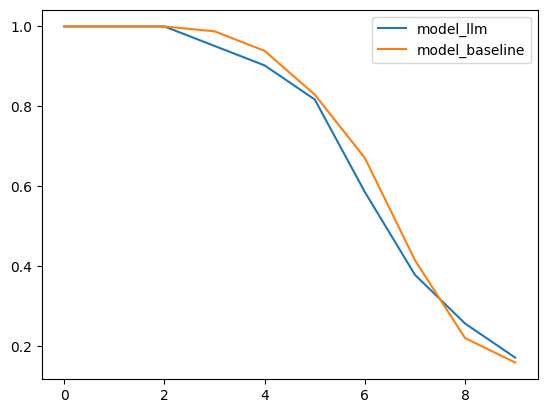

In [16]:
res_tn = []
res_bs = []
for i in range(0, 100, 10):
    func_ = partial(evaluate_multirc_example_llm, threshold_total=i/100)
    res_tn.append(evaluate_task_llm(model_llm, mult_dataset, torch.device("cuda"), func_))
    res_bs.append(evaluate_task_llm(model_baseline, mult_dataset, torch.device("cuda"), func_))
    print(i, res_tn[-1], res_bs[-1])


import matplotlib.pyplot as plt
plt.plot(res_tn, label="model_llm")
plt.plot(res_bs, label="model_baseline")

plt.legend()
plt.show()

0 1.0 1.0
10 1.0 1.0
20 1.0 1.0
30 0.9390243902439024 0.9390243902439024
40 0.7804878048780488 0.7926829268292683
50 0.7073170731707317 0.7195121951219512
60 0.4268292682926829 0.4146341463414634
70 0.25609756097560976 0.23170731707317074
80 0.0975609756097561 0.08536585365853659
90 0.012195121951219513 0.0


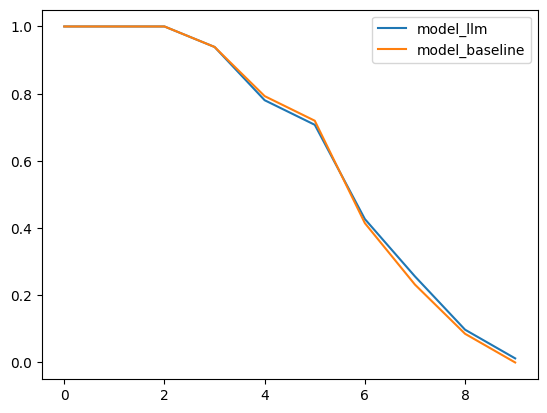

In [17]:
res_tn = []
res_bs = []
for i in range(0, 100, 10):
    func_ = partial(evaluate_multirc_example_llm, threshold_total=i/100, threshold=2)
    res_tn.append(evaluate_task_llm(model_llm, mult_dataset, torch.device("cuda"), func_))
    res_bs.append(evaluate_task_llm(model_baseline, mult_dataset, torch.device("cuda"), func_))
    print(i, res_tn[-1], res_bs[-1])


import matplotlib.pyplot as plt
plt.plot(res_tn, label="model_llm")
plt.plot(res_bs, label="model_baseline")

plt.legend()
plt.show()

In [18]:
from transformers import BertModel, BertTokenizer

tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")
model_bert = BertModel.from_pretrained("bert-base-uncased")



In [19]:
text = "Hello, my dog is cute"
ed = tokenizer_bert(text, return_tensors="pt", padding='max_length', max_length=512, truncation=True, add_special_tokens=True)
print(ed['input_ids'][0][0:10])
print(ed['attention_mask'][0][0:10])
print(tokenizer_bert.decode(ed['input_ids'][0][0:10]))

tensor([  101,  7592,  1010,  2026,  3899,  2003, 10140,   102,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])
[CLS] hello, my dog is cute [SEP] [PAD] [PAD]


In [20]:
model_bert(**ed)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.1144,  0.1937,  0.1250,  ..., -0.3827,  0.2107,  0.5407],
         [ 0.5308,  0.3207,  0.3665,  ..., -0.0036,  0.7579,  0.0388],
         [-0.4877,  0.8849,  0.4256,  ..., -0.6976,  0.4458,  0.1231],
         ...,
         [-0.4453, -0.1012,  0.1173,  ...,  0.2609,  0.0752, -0.3440],
         [-0.1612, -0.0660,  0.5640,  ...,  0.2657, -0.0086, -0.2123],
         [-0.1476, -0.0595,  0.6989,  ...,  0.1465, -0.0229,  0.0711]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-7.1946e-01, -2.1445e-01, -2.9576e-01,  3.6603e-01,  2.7968e-01,
          2.2183e-02,  5.7299e-01,  6.2331e-02,  5.9585e-02, -9.9965e-01,
          5.0145e-02,  4.4756e-01,  9.7612e-01,  3.3989e-02,  8.4494e-01,
         -3.6905e-01,  9.8648e-02, -3.7169e-01,  1.7371e-01,  1.1515e-01,
          4.4133e-01,  9.9525e-01,  3.7221e-01,  8.2881e-02,  2.1402e-01,
          6.8965e-01, -6.1042e-01,  8.7136e-01,  9.4158e-01,  5.737

### GLUPOSTI

In [21]:
tokenizer.decode([ 1057,  1012,  1055,  1012,  3187,  1997,  2110,  2888,  7618,  2121,
          3641,  9530,  3436, 11916,  3488,  4567,  2039,  3053,  2871,  2086,
          3283,  2000,  2886,  7394,  1010, 28647,  2094,  2058,  1996,  2235,
          2479,  1005,  1055, 10813,  1997,  3629,  2000, 13491,  1010,  2429,
          2000, 11703, 24938,  2231,  5491,  6866,  3784,  9317,  1012,  1999,
          2195,  2317,  2160,  6295,  1010,  7618,  2121, 11886,  2005,  2844,
          2895,  2000,  2644, 11794,  1010, 19725,  2008,  2010,  4297,  9236,
          3258,  1999,  3088,  2001,  2437,  1996,  1057,  1012,  1055,  1012,
          2298,  5410,  1012,  2002,  5275,  2008,  7394,  1005,  1055,  4506,
          2020,  4439, 10069,  2105,  1996,  2088,  1997,  1037,  7289,  2679,
          2162,  2008,  2071, 14437,  2058,  2046,  3763,  2637,  1998,  2130,
          4078,  2696, 14454,  4697,  1996,  2690,  2264,  1012,  1999,  1037,
          2186,  1997,  9530,  3436, 11916,  3488,  2008,  2628,  1010,  7047,
         15844,  2013,  1037,  2510, 15823,  2000, 14369, 18886,  9681,  1998,
          5471,  1997,  9642,  8831,  1012,  1030, 12944,  2059,  1011,  1057,
          1012,  1055,  1012,  3187,  1997,  2110, 18748,  2011, 26000,  2140,
         11794,  1005,  1055,  3247,  2000,  4604,  3629,  2046, 13491,  1999,
          3339,  1030, 12944,  7618,  2121,  8615,  2009,  2052, 10083,  2010,
          3488,  2005,  3088,  1998,  2359,  2000,  2128,  9080, 13143,  1030,
         12944,  3881,  2039,  3488,  1999,  3299,  2000,  2886,  8831,  1998,
          2510, 14111,  1999,  7394,  1030, 12944,  1005,  1045,  2052,  2022,
          1999,  5684,  1997, 18856, 16429,  5677,  2075,  2068,  1010,  1005,
          7618,  2121,  2056,  1010,  2429,  2000,  1996,  5491,  1030, 12944,
          3488,  2196,  2724, 16453,  2004,  5261,  5708,  2001,  2700, 10760,
          9530,  3436, 11916,  3488, 14801,  2510,  7047,  2013, 10851, 22011,
          9642,  3719,  4755,  3629,  1998,  2162,  3430,  2000, 14369, 18886,
          9681,  2114,  7394,  7888,  1998, 25278,  1012])

" run Cl ser Cl visit anythingederal member 58 fall center Han alone disorders homosure En emailreetief carry minduments fraudters DEA Don comesput## age ret serching anythingBl mind Audioters gen mind Element 120045 Britain Sar-> opinions Clattle Assached sum Sonters 58 fall couples cut veh Ang mind ...alogtersacht video net customers Currentarrattle triedaffHowput run Cl ser Cl pick planning Clommactive video fraud ret ser briefselves produce revealsppingputoke anything help Swed German ; video issue Kickstarter comes fire yes.' experience someone acquises109 olderputepend Qu Clattle help repl anything Han alone disorders hom video groupstersigure lyricsien helpraelEnglish mind slicrollingpread experience opposition anything unlsect Clganoub University take run Cl ser Cl visit anythingederalilitary Mycollashingalog ret serraz mindligBl fire Audioattle pleganoub 58 fall cos investigches 87 net hom cut tried experienceduct mind sound entitledMartganoub rock En homattleication mindument

In [22]:
for i in range(20):
    print(i, " -> ", ds.passages[i])

NameError: name 'ds' is not defined

In [43]:
list(filter(lambda x: x.query.startswith("the continge"), ds.question_answer_objs))

[]

In [44]:
from training import train_LLM
from transformers import GPT2Tokenizer
from datasets import Boolq_dataset
from dataset_loaders import load_boolq
from models import Model_LLM
from transformers import GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
boolq_dataset = load_boolq("raw_data/BoolQ/train.jsonl", tokenizer)
eval_boolq_dataset = load_boolq("raw_data/BoolQ/dev.jsonl", tokenizer)

base_model = GPT2LMHeadModel.from_pretrained('gpt2')
model = Model_LLM(base_model, tokenizer)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [ ]:
train_LLM(model=model, optimizer=optimizer, dataset=boolq_dataset, eval_dataset=eval_boolq_dataset, epochs=1, batch_size=1)

In [26]:
import pandas as pd
path = "raw_data/multirc-v2/splitv2/dev_83-fixedIds.json"
with open(path) as f:
    raw_dataset = json.load(f)

dataset = pd.DataFrame(raw_dataset['data'])

In [30]:
dataset["paragraph"][0]

{'text': '<b>Sent 1: </b>(CNN) -- Air New Zealand\'s latest in-flight safety video, released Tuesday, is already another viral hit but is encountering some turbulence over its use of several bikini-clad Sports Illustrated models.<br><b>Sent 2: </b>View the video here Previous versions of the video -- starring anything from Hobbits to Bear Grylls to New Zealand\'s all conquering All Blacks rugby team -- have revolutionized the on-board safety message airlines deliver to passengers.<br><b>Sent 3: </b>The most recent effort though is being criticized by some as neither ground-breaking nor as creative, after the airline teamed up with Sports Illustrated magazine to produce what it\'s calling "The world\'s most beautiful safety video."<br><b>Sent 4: </b>The "Safety in Paradise" video, which rolls out on Air New Zealand flights at the end of February, is beautifully shot and certainly cheerful and fun.<br><b>Sent 5: </b>It was filmed in the Cook Islands -- home to several stunning beaches --